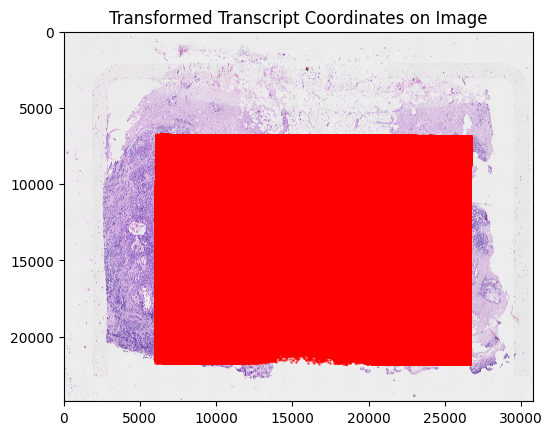

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tifffile import imread

# Load the spatial image
image_path = '../data/xenium/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.ome.tif'
img = imread(image_path)

# Load the Xenium data
xenium_data_path = '../data/xenium/outs/transcripts.parquet'
xenium_df = pd.read_parquet(xenium_data_path)

# Define the transformation matrix from the CSV file
transform_matrix = np.array([
    [1.7125010585876286, 0.008345081015717404, -10397.19948741904],
    [0.008345081015717404, -1.7125010585876286, 37211.538978661185],
    [0, 0, 1]
])

# Get the inverse matrix
transform_matrix_inv = np.linalg.inv(transform_matrix)

# Extract coordinates and apply scaling
coords = xenium_df[['x_location', 'y_location']].values
micron_to_pixel = 0.2125  # Microns per pixel
coords_scaled = coords / micron_to_pixel

# Function to transform coordinates
def transform_coordinates(coords, transform_matrix):
    coords = np.hstack((coords, np.ones((len(coords), 1))))
    transformed_coords = np.dot(transform_matrix, coords.T).T
    # Return only the x and y coordinates
    return transformed_coords[:, :2]

# Apply the transformation to the scaled coordinates
transformed_coords = transform_coordinates(coords_scaled, transform_matrix_inv)

# Update the DataFrame with the transformed coordinates
xenium_df[['x_location_transformed', 'y_location_transformed']] = transformed_coords

# Visualize the transformed coordinates over the image
plt.imshow(img, cmap='gray')
plt.scatter(xenium_df['x_location_transformed'], xenium_df['y_location_transformed'], s=1, alpha=0.5, c='red')
plt.title('Transformed Transcript Coordinates on Image')
plt.show()


In [63]:
xenium_df

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv,x_location_transformed,y_location_transformed
0,281474976710656,565,0,b'SEC11C',4.395842,328.666473,12.019493,18.662479,5981.804361,20855.340013
1,281474976710657,540,0,b'NegControlCodeword_0502',5.074415,236.964844,7.608510,18.634956,5982.441069,21107.335432
2,281474976710658,562,0,b'SEC11C',4.702023,322.797150,12.289083,18.662479,5982.567120,20871.472398
3,281474976710659,271,0,b'DAPK3',4.906601,581.428650,11.222615,20.821745,5986.592507,20160.783340
4,281474976710660,291,0,b'TCIM',5.660699,720.851746,9.265523,18.017488,5990.531645,19777.673639
...,...,...,...,...,...,...,...,...,...,...
42638078,281805689407068,-1,0,b'HOXD8',5218.000488,5295.519531,30.560934,20.061079,20374.743128,7276.769846
42638079,281805689407071,135717,1,b'LUM',5218.804688,4792.928223,38.440426,21.389278,20370.223389,8657.848701
42638080,281805689407078,-1,0,b'LUM',5217.404785,5425.386230,30.519602,21.960102,20374.845524,6919.902408
42638081,281805689407083,-1,0,b'NARS',5220.155273,4839.704102,32.180698,25.970398,20374.560881,8529.330911


In [64]:
micron_to_pixel = 0.2125
bin_size_microns = 2.0
bin_size_pixels = bin_size_microns / micron_to_pixel
bin_size_pixels


9.411764705882353

In [65]:

# example: if coorinate is 5 -> bin 0, if coordinate 30 -> bin 3 (floor division for coordinate/bin_size_pixels)
x_bins = np.floor(transformed_coords[:, 0] / bin_size_pixels).astype(int)
y_bins = np.floor(transformed_coords[:, 1] / bin_size_pixels).astype(int)

# because of the shifted coordinates, we go to 0 and 1
x_bins -= x_bins.min()
y_bins -= y_bins.min()

xenium_df['x_bins'] = x_bins
xenium_df['y_bins'] = y_bins

xenium_df['feature_name'] = xenium_df['feature_name'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

result_df = xenium_df[['x_bins', 'y_bins', 'transcript_id', 'feature_name', 'x_location_transformed', 'y_location_transformed']]

print(result_df.head())


   x_bins  y_bins    transcript_id             feature_name   
0       0    1499  281474976710656                   SEC11C  \
1       0    1526  281474976710657  NegControlCodeword_0502   
2       0    1501  281474976710658                   SEC11C   
3       1    1426  281474976710659                    DAPK3   
4       1    1385  281474976710660                     TCIM   

   x_location_transformed  y_location_transformed  
0             5981.804361            20855.340013  
1             5982.441069            21107.335432  
2             5982.567120            20871.472398  
3             5986.592507            20160.783340  
4             5990.531645            19777.673639  


In [66]:
result_df.to_csv('transcripts_binned.csv', index=False)

In [75]:
import pandas as pd
# Create a 'bin' column that combines x_bins and y_bins as tuples
result_df['bin'] = list(zip(result_df['x_bins'], result_df['y_bins']))

# Create a pivot table
pivot_table = pd.pivot_table(result_df, 
                             index='bin', 
                             columns='feature_name', 
                             aggfunc='size', 
                             fill_value=0)


# Print the resulting matrix
print(pivot_table)


/var/folders/fd/jw2fvp1178s0spb_1sy9f51h0000gn/T/ipykernel_36177/663148751.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['bin'] = list(zip(result_df['x_bins'], result_df['y_bins']))


feature_name  ABCC11  ACTA2  ACTG2  ADAM9  ADGRE5  ADH1B  ADIPOQ  AGR3  AHSP   
bin                                                                            
(0, 1376)          0      0      0      0       0      0       0     0     0  \
(0, 1400)          0      1      0      0       0      0       0     0     0   
(0, 1402)          0      0      0      0       0      0       0     0     0   
(0, 1415)          0      0      0      0       0      0       0     0     0   
(0, 1425)          0      0      0      0       0      0       0     0     0   
...              ...    ...    ...    ...     ...    ...     ...   ...   ...   
(2201, 146)        0      0      0      0       0      0       0     0     0   
(2201, 147)        0      0      0      0       0      0       0     0     0   
(2201, 148)        0      0      0      0       0      0       0     0     0   
(2201, 153)        0      0      0      0       0      0       0     0     0   
(2201, 154)        0      0      0      

In [68]:
pivot_table.to_csv('transcripts_binned_hd_style.csv', index=False)

In [69]:
non_zero_rows = pivot_table[(pivot_table > 10).any(axis=1)]

# Display the rows with non-zero values
print(non_zero_rows)


feature_name  ABCC11  ACTA2  ACTG2  ADAM9  ADGRE5  ADH1B  ADIPOQ  AGR3  AHSP   
bin                                                                            
(183, 887)         0      5      0      0       0      0       0     0     0  \
(347, 215)         0      1      0      2       0      0       0     0     0   
(417, 1199)        0      0      1      0       0      0       0     0     0   
(590, 696)         0      2      0      1       0      0       0     0     0   
(610, 748)         0      0      0      0       0      0       0     0     0   
(665, 661)         0      0      0      1       0      0       0     0     0   
(679, 669)         0      1      1      2       0      0       0     0     0   
(763, 716)         0      0      0      1       0      0       0     0     0   
(767, 431)         0      0      0      0       0      0       0     0     0   
(823, 682)         0      4      1      1       0      0       0     0     0   
(848, 804)         0      0      0      

In [76]:
import scanpy as sc
import anndata as ad
import pandas as pd

df = pivot_table

# Extract x_bins and y_bins from the index
df['x_bins'] = [x for x, y in df.index]
df['y_bins'] = [y for x, y in df.index]

# Convert index to string format to avoid the TypeError
df.index = df.index.map(str)

# Create AnnData object
X = df.drop(columns=['x_bins', 'y_bins']).values  # Dropping the new columns for the AnnData matrix
adata = ad.AnnData(X=X)
adata.obsm['spatial'] = df[['x_bins', 'y_bins']].values  # Spatial information, mby do the whole polygon
adata.var_names = df.columns[:-2]  # Setting gene/feature names (excluding the last two columns)
adata.obs_names = df.index.astype(str)  # Ensuring that bin names are strings

# Add metadata
metadata = pd.DataFrame({
    'bin': df.index,
    'sample': ['sample1' for _ in range(len(df))],  # Replace with transcript ids and other dat
})
metadata.set_index('bin', inplace=True)
adata.obs = metadata

# Save AnnData object
adata.write('transcripts_anndata.h5ad')
adata.to_df()


feature_name,ABCC11,ACTA2,ACTG2,ADAM9,ADGRE5,ADH1B,ADIPOQ,AGR3,AHSP,AIF1,...,ZEB2,ZNF562,antisense_ADCY4,antisense_BCL2L15,antisense_LGI3,antisense_MYLIP,antisense_PROKR2,antisense_SCRIB,antisense_TRMU,antisense_ULK3
bin,,,,,,,,,,,,,,,,,,,,,
"(0, 1376)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(0, 1400)",0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(0, 1402)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(0, 1415)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(0, 1425)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(2201, 146)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(2201, 147)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(2201, 148)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
